In [1]:
# import tensorflow as tf
# print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization, TimeDistributed, Bidirectional
# from tensorflow.keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tempfile

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random


# Parameters
WINDOW_SIZE = 300
STEP_SIZE = 275
TOLERANCE = 0.1
MAX = 20000
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')
LABELS = []
X = []
y = []
well_represented = ['Fridge','Freezer','Washing Machine','Washer Dryer','Tumble Dryer','Dishwasher','Microwave','Toaster','Kettle',
                'Computer','Electric Heater','Hi-Fi','Overhead Fan']


In [ ]:

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def process_file(file_path, label_idx):
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)
    with open(file_path) as f:
        appliance_name = f.readline().strip().split(",")[1]

    if appliance_name not in df.columns:
        return []

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    return [(window, label_idx) for window in extract_windows(signal)]

def load_balanced_dataset(data_dir, well_represented=well_represented):
    global LABELS, X, y

    label_map = {name: i for i, name in enumerate(well_represented)}
    all_windows = {label: [] for label in well_represented}

    # Step 1: Load all data first
    for class_dir in sorted(Path(data_dir).iterdir()):
        if not class_dir.is_dir():
            continue
        class_name = class_dir.name
        if class_name not in well_represented:
            continue
        label_idx = label_map[class_name]
        if class_name not in LABELS:
            LABELS.append(class_name)
        for file in class_dir.glob("*.csv"):
            windows = process_file(file, label_idx)
            all_windows[class_name].extend(windows)

    # Step 2: Select reference class and determine target range
    ref_class = random.choice(well_represented)
    original_ref_count = len(all_windows[ref_class])
    ref_count = min(MAX, original_ref_count)
    print(f"Reference class: {ref_class} (using {ref_count} windows, originally had {original_ref_count})")

    min_required = int(ref_count * (1 - TOLERANCE))
    max_allowed = int(ref_count * (1 + TOLERANCE))
    cap = min(MAX, max_allowed)


    # Step 3: Apply sampling per class
    for label in well_represented:
        class_windows = all_windows[label]
        # needed = random.randint(min_required, cap)
        needed = MAX

        if len(class_windows) >= needed:
            chosen = random.sample(class_windows, needed)
        else:
            repeat_count = (needed // len(class_windows)) + 1
            extended = class_windows * repeat_count
            chosen = extended[:needed]
            chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
                      for (w, lbl) in chosen]

        for window, label_idx in chosen:
            X.append(window)
            y.append(label_idx)

        print(f"{label}: {len(chosen)} samples")

    print("\nClass balance (target ±{:.1f}%, max cap = {}):".format(TOLERANCE * 100, MAX))
    for label in well_represented:
        print(f"{label}: {sum(np.array(y) == label_map[label])} windows")

    X_np = np.array(X)[..., np.newaxis]
    y_np = to_categorical(y, num_classes=len(LABELS))
    return X_np, y_np


X, y = load_balanced_dataset(DATA_DIR)

Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Pr

In [6]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 12105 samples
Dishwasher          : 11943 samples
Electric Heater     : 12059 samples
Freezer             : 11983 samples
Fridge              : 12088 samples
Hi-Fi               : 11970 samples
Kettle              : 11951 samples
Microwave           : 12111 samples
Overhead Fan        : 11923 samples
Toaster             : 11999 samples
Tumble Dryer        : 11957 samples
Washer Dryer        : 11949 samples
Washing Machine     : 11962 samples

Class distribution in VALIDATION set:
Computer            : 5552 samples
Dishwasher          : 5672 samples
Electric Heater     : 5560 samples
Freezer             : 5646 samples
Fridge              : 5490 samples
Hi-Fi               : 5614 samples
Kettle              : 5627 samples
Microwave           : 5495 samples
Overhead Fan        : 5654 samples
Toaster             : 5613 samples
Tumble Dryer        : 5649 samples
Washer Dryer        : 5644 samples
Washing Machine     : 5584 samples

Cla

In [8]:
from keras.layers import Activation, Multiply, Add
from keras.utils import get_custom_objects
from keras.activations import relu

def relu6_div6(x):
    return relu(x, max_value=6) / 6

get_custom_objects().update({'relu6_div6': Activation(relu6_div6)})

def Conv1DGLUBlock(filters, kernel_size):
    def block(x):
        linear = Conv1D(filters, kernel_size, padding='same')(x)
        gate = Conv1D(filters, kernel_size, padding='same')(x)
        gate_out = Activation(relu6_div6)(gate)
        return Multiply()([linear, gate_out])
    return block

def ResidualBlock(filters, kernel_size):
    def block(x):
        out = Conv1DGLUBlock(filters, kernel_size)(x)
        out = Conv1D(filters, kernel_size=1, padding='same')(out)
        if x.shape[-1] != out.shape[-1]:
            x = Conv1D(filters, kernel_size=1, padding='same')(x)  # 1x1 conv to match channels
        return Add()([x, out])
    return block

In [ ]:
# from Conv1D_GLU import Conv1DGLU
# from ResidualBlock import ResidualBlock
from keras.models import Model
from keras.layers import Add

def build_glu_cnn_lstm_model(window_size, num_classes):
    input_layer = Input(shape=(window_size, 1))
    print(f"Input shape: {input_layer.shape}")

    # x = Conv1DGLU(filters=64, kernel_size=5)(input_layer)
    x = ResidualBlock(filters=64, kernel_size=5)(input_layer)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    print(f"Input shape: {x.shape}")
    # input_layer = x  # Save the input for residual connection
    # x2 = Conv1DGLU(filters=128, kernel_size=3)(x)
    x = ResidualBlock(filters=128, kernel_size=3)(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Dropout(0.2)(x)

    # Optional LSTM
    x = LSTM(64)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [114]:
model = build_glu_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Input shape: (None, 300, 1)
Input shape: (None, 150, 64)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 300, 64)   │          0 │ conv1d_107[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_126        │ (None, 300, 64)   │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_126[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 300, 64)   │          0 │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 150, 64)   │          0 │ add_108[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 150, 128)  │          0 │ conv1d_111[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_127        │ (None, 150, 128)  │          0 │ conv1d_110[0][0], │
│ (Multiply)          │                   │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_127[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_109 (Add)       │ (None, 150, 128)  │          0 │ conv1d_113[0][0], │
│                     │                   │            │ conv1d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 75, 128)   │          0 │ add_109[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 75, 128)   │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     49,408 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      8,320 │ lstm_13[0][0]   

 Total params: 138,701 (541.80 KB)

 Trainable params: 138,701 (541.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 80ms/step - accuracy: 0.3831 - loss: 1.6085 - val_accuracy: 0.5754 - val_loss: 1.1115
Epoch 2/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 218s 89ms/step - accuracy: 0.5968 - loss: 1.0672 - val_accuracy: 0.7507 - val_loss: 0.6808
Epoch 3/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 198s 81ms/step - accuracy: 0.7068 - loss: 0.8023 - val_accuracy: 0.7393 - val_loss: 0.6531
Epoch 4/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 82ms/step - accuracy: 0.7467 - loss: 0.6835 - val_accuracy: 0.7954 - val_loss: 0.5785
Epoch 5/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 206s 84ms/step - accuracy: 0.7791 - loss: 0.5828 - val_accuracy: 0.7992 - val_loss: 0.5360
Epoch 6/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 208s 85ms/step - accuracy: 0.7953 - loss: 0.5403 - val_accuracy: 0.8439 - val_loss: 0.4225
Epoch 7/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 81ms/step - accuracy: 0.8292 - loss: 0.4639 - val_accuracy: 0.8550 - val_loss: 0.3860
Epoch 8/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 207s 85ms/step - accuracy: 

In [115]:
from sklearn.metrics import accuracy_score

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
test_accuracy = accuracy_score(y_true, probs)
print("Test Accuracy:", test_accuracy)

975/975 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step
Test Accuracy: 0.8754487179487179


In [116]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          figsize=(12, 10),
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.show()


Confusion matrix, without normalization
[[1783  209    1    0    0    1  291    0    0   41    0   16    1]
 [ 194 1994    0    2    0    0  183    0    0    8    0    4    0]
 [   1    0 2315    5    4   31    2    2    3    7    8    0    3]
 [   0    0    8 2313    0    1    0    0    0   13   27    0    9]
 [   0    0   39   29 2295    0    0    0    6   11   30    0   12]
 [   0    0 1028    3    0 1341    0    0    0    1   43    0    0]
 [  13   13    0    0    0    1 2156    0    0  150    1   88    0]
 [   0    0    0    0    0    0    0 2394    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0 2418    0    0    0    5]
 [  85    8    1    1    1    1  102    0   10 2061    0  118    0]
 [   0    0  580    3    7   33    0    0   54    0 1593    0  124]
 [   1    0    0    0    0    0    1    0   10  113    0 2280    2]
 [   0    0    0    0    0    0    0    0   71   12    0    0 2371]]


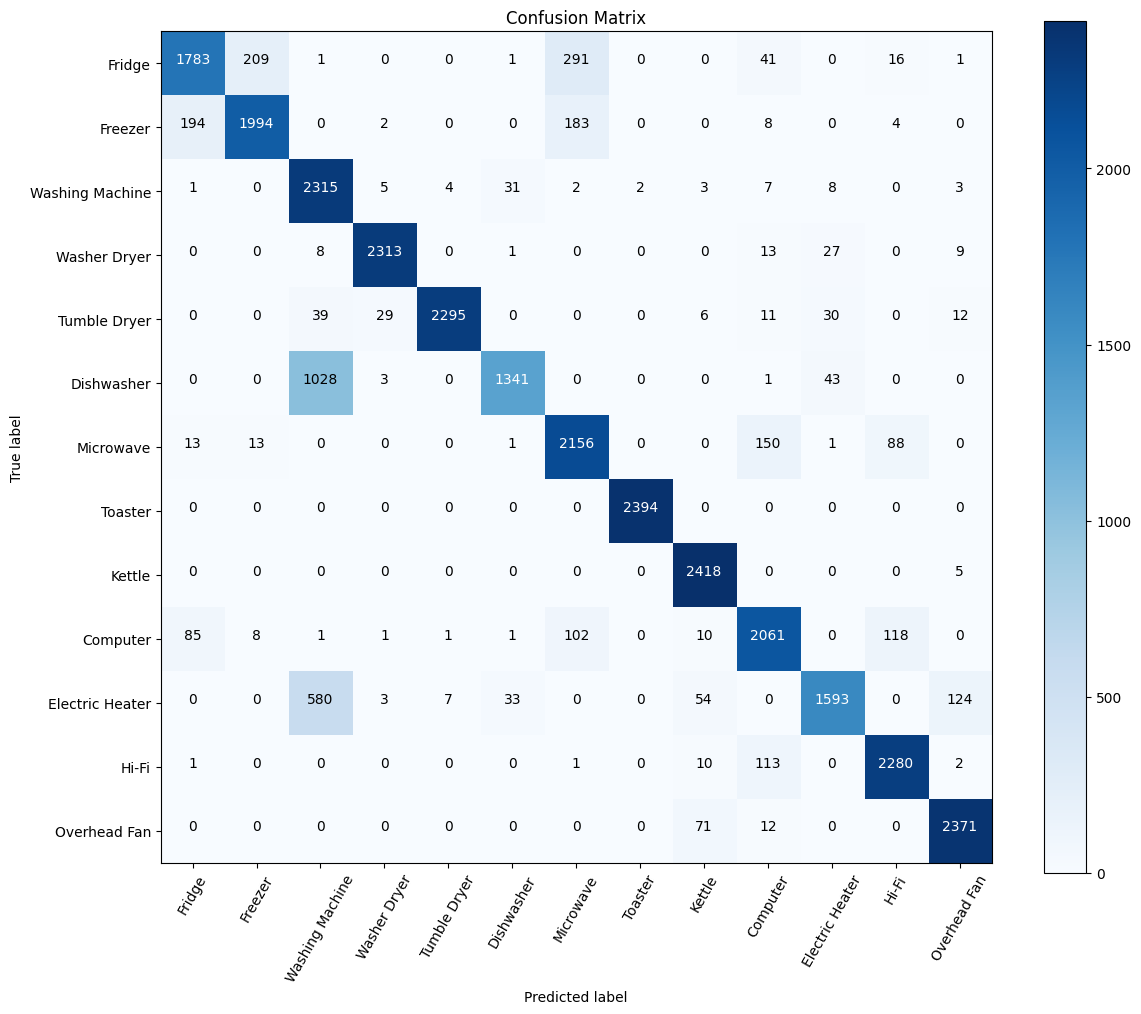

In [117]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)

In [118]:
from sklearn.metrics import classification_report 
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1),target_names=LABELS))

                 precision    recall  f1-score   support

       Computer       0.86      0.76      0.81      2343
     Dishwasher       0.90      0.84      0.87      2385
Electric Heater       0.58      0.97      0.73      2381
        Freezer       0.98      0.98      0.98      2371
         Fridge       0.99      0.95      0.97      2422
          Hi-Fi       0.95      0.56      0.70      2416
         Kettle       0.79      0.89      0.84      2422
      Microwave       1.00      1.00      1.00      2394
   Overhead Fan       0.94      1.00      0.97      2423
        Toaster       0.85      0.86      0.86      2388
   Tumble Dryer       0.94      0.67      0.78      2394
   Washer Dryer       0.91      0.95      0.93      2407
Washing Machine       0.94      0.97      0.95      2454

       accuracy                           0.88     31200
      macro avg       0.89      0.88      0.87     31200
   weighted avg       0.89      0.88      0.87     31200



In [ ]:
# from keras import ops
from keras.models import save_model

save_model(model,'GLU_CNN_LSTM_model.keras')
print('Saved model to: GLU_CNN_LSTM_model.keras')


Saved model to: GLU_CNN_LSTM_model.keras


In [87]:
WINDOW_SIZE = 300
STEP_SIZE = 275

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def prepare_inference_data(aggregate_file_path):
    X_all = []
    column_name = 'Aggregate'  # Change to 'mains' if needed

    for file_path in sorted(Path(aggregate_file_path).glob("*.csv")):
        print(f"Processing: {file_path.name}")
        df = pd.read_csv(file_path)

        # Use 'aggregate' or 'mains' column
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in {file_path.name}")

        signal = df[column_name].fillna(0).values.astype(np.float32)
        windows = extract_windows(signal)
        X_all.extend(windows)

    X_all_np = np.array(X_all)[..., np.newaxis]  # shape: (n_windows, window_size, 1)
    print(f"\nTotal windows extracted: {X_all_np.shape[0]}")
    return X_all_np


In [88]:
path = Path(f"{DATA_DIR}/Aggregate")
X_infer = prepare_inference_data(path)


Processing: Aggregate_House_1.csv_0.csv
Processing: Aggregate_House_1.csv_1.csv
Processing: Aggregate_House_1.csv_10.csv
Processing: Aggregate_House_1.csv_11.csv
Processing: Aggregate_House_1.csv_12.csv
Processing: Aggregate_House_1.csv_13.csv
Processing: Aggregate_House_1.csv_14.csv
Processing: Aggregate_House_1.csv_15.csv
Processing: Aggregate_House_1.csv_16.csv
Processing: Aggregate_House_1.csv_17.csv
Processing: Aggregate_House_1.csv_18.csv
Processing: Aggregate_House_1.csv_19.csv
Processing: Aggregate_House_1.csv_2.csv
Processing: Aggregate_House_1.csv_20.csv
Processing: Aggregate_House_1.csv_21.csv
Processing: Aggregate_House_1.csv_22.csv
Processing: Aggregate_House_1.csv_23.csv
Processing: Aggregate_House_1.csv_24.csv
Processing: Aggregate_House_1.csv_25.csv
Processing: Aggregate_House_1.csv_3.csv
Processing: Aggregate_House_1.csv_4.csv
Processing: Aggregate_House_1.csv_5.csv
Processing: Aggregate_House_1.csv_6.csv
Processing: Aggregate_House_1.csv_7.csv
Processing: Aggregate_Ho

In [9]:
from keras.models import load_model

loaded_model = load_model('GLU_CNN_LSTM_model.keras')

# predictions = loaded_model.predict(X_infer)
# predicted_classes = np.argmax(predictions, axis=1)

In [138]:
from keras.metrics import BinaryAccuracy, AUC, Recall
from keras.layers import TimeDistributed, Dense, Bidirectional
from keras.optimizers import Adam

# loaded_model.summary()
# for layer in loaded_model.layers[:8]:
#     layer.trainable = False
x = loaded_model.layers[-5].input

# print(f"Shape of second-last layer output: {x.shape}")
# seq2seq = LSTM(64, return_sequences=True, name="lstm_seq")(x)
# seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(seq2seq)
# Compile

# seq2seq = ResidualBlock(filters=128, kernel_size=3)(x)
# seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

# seq2seq = ResidualBlock(filters=128, kernel_size=3)(seq2seq)
# seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

seq2seq = Bidirectional(LSTM(64, return_sequences=True))(x)

seq2seq = Dropout(0.2)(seq2seq)
seq2seq = Bidirectional(LSTM(64, return_sequences=True))(seq2seq)
seq2seq = TimeDistributed(Dense(128, activation='relu'))(seq2seq)
seq2seq = Dropout(0.2)(seq2seq)


seq2seq = Dense(9, activation='sigmoid')(seq2seq)
# seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(x)

import tensorflow as tf

# def weighted_binary_crossentropy(pos_weight=4.0):
#     def loss_fn(y_true, y_pred):
#         bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
#         weights = 1.0 + pos_weight * y_true  # weight = 5 if y_true==1, else 1
#         return tf.reduce_mean(bce * weights)
#     return loss_fn

loss = keras.losses.BinaryCrossentropy()
weighted_loss = lambda y_true, y_pred: loss(y_true, y_pred) * (1 + 5*y_true)

import tensorflow as tf
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss

seq2seq_model = Model(inputs=loaded_model.input, outputs=seq2seq)
seq2seq_model.compile(optimizer=Adam(learning_rate=0.01), loss=focal_loss(), metrics=[BinaryAccuracy(name='binary_accuracy'),AUC(name='auc'), Recall(name='recall')])

# # # Summary
seq2seq_model.summary()






Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 300, 64)   │          0 │ conv1d_107[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_126        │ (None, 300, 64)   │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_126[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 300, 64)   │          0 │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 150, 64)   │          0 │ add_108[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 150, 128)  │          0 │ conv1d_111[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_127        │ (None, 150, 128)  │          0 │ conv1d_110[0][0], │
│ (Multiply)          │                   │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_127[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_109 (Add)       │ (None, 150, 128)  │          0 │ conv1d_113[0][0], │
│                     │                   │            │ conv1d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 75, 128)   │          0 │ add_109[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 75, 128)   │     98,816 │ max_pooling1d_31… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 75, 128)   │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 294,601 (1.12 MB)

 Trainable params: 215,305 (841.04 KB)

 Non-trainable params: 79,296 (309.75 KB)

In [11]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # What to track
    factor=0.5,           # Reduce LR by this factor
    patience=3,           # Wait this many epochs with no improvement
    min_lr=1e-6,          # Minimum LR to avoid going too low
    verbose=1             # Print updates
)


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PARAMETERS
WINDOW_SIZE = 300
STRIDE = 50
TARGET_COLUMNS = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
                  'Television', 'Microwave', 'Kettle', 'Hi-Fi', 'Electric Heater']
AGG_COLUMN = 'Aggregate'
UNIX_COLUMN = 'Unix'
NUM_SAMPLES = 50000

# Load CSV
df = pd.read_csv(f'{DATA_DIR}/House_9.csv')

# Drop unnecessary columns (keep only aggregate + target appliances)
df = df[[AGG_COLUMN, *TARGET_COLUMNS, UNIX_COLUMN]]



# Normalize (fit on full dataset or just training)
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Function to create windowed sequences
def create_sequences(data, window_size=300, stride=1):
    count = 0
    X = []
    y = []

    # Get column indices
    agg_idx = data.columns.get_loc(AGG_COLUMN)
    target_idxs = [data.columns.get_loc(col) for col in TARGET_COLUMNS]

    for i in range(0, len(data) - window_size, stride):
        if count >= NUM_SAMPLES:
            break

        window = data.iloc[i:i + window_size].fillna(0).values.astype(np.float32)

        # Normalize the window
        # max_val = np.max(np.abs(window))
        # if max_val > 0:
        #     window = window / max_val

        # Aggregate signal (1D input)
        X.append(window[:, agg_idx].reshape(-1, 1))  # shape: (300, 1)

        # Extract target appliance usage
        target_data = window[:, target_idxs]  # shape: (300, 9)

        # Downsample to 75 by averaging every 4 rows
        chunks = np.split(target_data[:300], 75)  # 300/4 = 75
        mean_chunks = np.array([chunk.mean(axis=0) for chunk in chunks])  # shape: (75, 9)
        y.append(mean_chunks)

        count += 1
        print(count)

    y = np.array(y)

# Apply threshold after conversion to NumPy array
    y = (y > 10).astype(int)

    return np.array(X), np.array(y)

X, y = create_sequences(df, window_size=WINDOW_SIZE, stride=STRIDE)

# Use last time step label or mean if desired
# y = y[:, -1, :]  # Optional

# Print shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [52]:

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Final shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")


# print("X train: ", X_train)
# print("y train: ", y_train)

print(X_train[0], y_train[0])

Train: (40000, 300, 1), (40000, 75, 9)
Val:   (5000, 300, 1), (5000, 75, 9)
Test:  (5000, 300, 1), (5000, 75, 9)
[[ 161.]
 [ 160.]
 [ 160.]
 [ 162.]
 [ 161.]
 [ 159.]
 [ 159.]
 [ 162.]
 [ 159.]
 [ 161.]
 [ 161.]
 [ 161.]
 [ 160.]
 [1627.]
 [1611.]
 [1646.]
 [1629.]
 [1629.]
 [1614.]
 [1614.]
 [1614.]
 [1603.]
 [1624.]
 [1624.]
 [1647.]
 [1647.]
 [1647.]
 [1637.]
 [1637.]
 [1637.]
 [1637.]
 [1640.]
 [1644.]
 [1644.]
 [1644.]
 [1608.]
 [1608.]
 [1616.]
 [1616.]
 [1646.]
 [1607.]
 [1607.]
 [1607.]
 [1621.]
 [1612.]
 [1621.]
 [1628.]
 [1617.]
 [1617.]
 [ 383.]
 [ 257.]
 [ 257.]
 [1626.]
 [1626.]
 [1653.]
 [1653.]
 [1653.]
 [1653.]
 [1608.]
 [1608.]
 [1641.]
 [1621.]
 [1621.]
 [1637.]
 [1637.]
 [1637.]
 [1634.]
 [1626.]
 [1631.]
 [1631.]
 [1631.]
 [1610.]
 [1632.]
 [1603.]
 [1611.]
 [1611.]
 [1634.]
 [1634.]
 [1604.]
 [1617.]
 [1617.]
 [1658.]
 [1658.]
 [1624.]
 [1609.]
 [1609.]
 [1607.]
 [1607.]
 [1608.]
 [1646.]
 [1621.]
 [1600.]
 [1600.]
 [1621.]
 [1621.]
 [1609.]
 [1617.]
 [1609.]
 [160

In [137]:

# Create a DataFrame
def imbalance_calc (y, dataset):
    y_flat = y.reshape(-1, y.shape[-1])
    on_percentage = 100 * np.mean(y_flat, axis=0)
    off_percentage = 100 - on_percentage
    on_off_df = pd.DataFrame({
        f'Appliance in {dataset}': [f'{TARGET_COLUMNS[i]}' for i in range(y.shape[-1])],
        'ON (%)': on_percentage,
        'OFF (%)': off_percentage
    })
    print(on_off_df)

imbalance_calc(y_train,'Train')
imbalance_calc(y_test,'Test')
imbalance_calc(y_val,'Val')

  Appliance in Train     ON (%)    OFF (%)
0             Fridge  52.604667  47.395333
1       Washer Dryer   3.839333  96.160667
2    Washing Machine   2.595000  97.405000
3         Dishwasher   6.291333  93.708667
4         Television  72.558467  27.441533
5          Microwave   0.185800  99.814200
6             Kettle   1.153467  98.846533
7              Hi-Fi  26.479933  73.520067
8    Electric Heater   1.334533  98.665467
  Appliance in Test     ON (%)    OFF (%)
0            Fridge  52.586400  47.413600
1      Washer Dryer   4.167200  95.832800
2   Washing Machine   2.802133  97.197867
3        Dishwasher   6.215200  93.784800
4        Television  73.084800  26.915200
5         Microwave   0.113867  99.886133
6            Kettle   1.107200  98.892800
7             Hi-Fi  27.802933  72.197067
8   Electric Heater   1.047467  98.952533
  Appliance in Val     ON (%)    OFF (%)
0           Fridge  52.961600  47.038400
1     Washer Dryer   3.540533  96.459467
2  Washing Machine   2.4082

In [139]:

history = seq2seq_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val,y_val))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 183ms/step - auc: 0.9124 - binary_accuracy: 0.8640 - loss: 0.0066 - recall: 0.6429 - val_auc: 0.9269 - val_binary_accuracy: 0.8725 - val_loss: 0.0049 - val_recall: 0.7401
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 249ms/step - auc: 0.9242 - binary_accuracy: 0.8698 - loss: 0.0051 - recall: 0.6673 - val_auc: 0.9296 - val_binary_accuracy: 0.8727 - val_loss: 0.0047 - val_recall: 0.7310
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - auc: 0.9238 - binary_accuracy: 0.8701 - loss: 0.0052 - recall: 0.6662 - val_auc: 0.9271 - val_binary_accuracy: 0.8733 - val_loss: 0.0048 - val_recall: 0.7138
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 162s 260ms/step - auc: 0.9255 - binary_accuracy: 0.8716 - loss: 0.0050 - recall: 0.6941 - val_auc: 0.9278 - val_binary_accuracy: 0.8734 - val_loss: 0.0048 - val_recall: 0.7374
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 248ms/step - auc: 0.9256 - binary_accuracy: 0.8714 - loss: 0.0050 - recall: 0.6939 - val_au

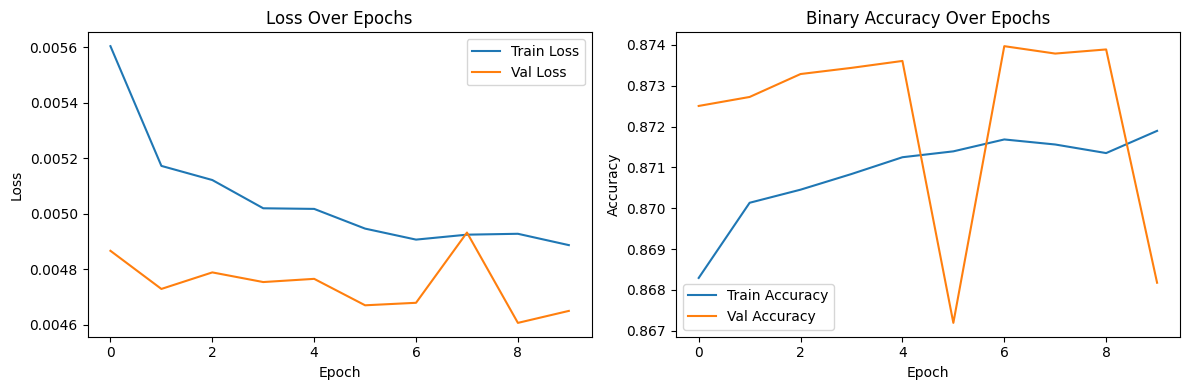

In [140]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [141]:
import matplotlib.pyplot as plt

# Settings

preds = seq2seq_model.predict(X_test)
preds_binary = (preds > 0.6).astype(int)


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step


In [142]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# y_test and preds_binary shape: (num_samples, num_appliances)

# Option 1: Overall accuracy (flatten all)
overall_accuracy = accuracy_score(y_test.flatten(), preds_binary.flatten())
print(f'Overall test accuracy: {overall_accuracy:.4f}')

# Option 2: Per-appliance accuracy
num_appliances = min(y_test.shape[1], len(TARGET_COLUMNS))

per_appliance_acc = []
for i in range(num_appliances):
    acc = accuracy_score(y_test[:, i], preds_binary[:, i])
    per_appliance_acc.append(acc)
    print(f'Accuracy for appliance {TARGET_COLUMNS[i]}: {acc:.4f}')



Overall test accuracy: 0.8647
Accuracy for appliance Fridge: 0.2308
Accuracy for appliance Washer Dryer: 0.2298
Accuracy for appliance Washing Machine: 0.2312
Accuracy for appliance Dishwasher: 0.2314
Accuracy for appliance Television: 0.2310
Accuracy for appliance Microwave: 0.2320
Accuracy for appliance Kettle: 0.2332
Accuracy for appliance Hi-Fi: 0.2354
Accuracy for appliance Electric Heater: 0.2364


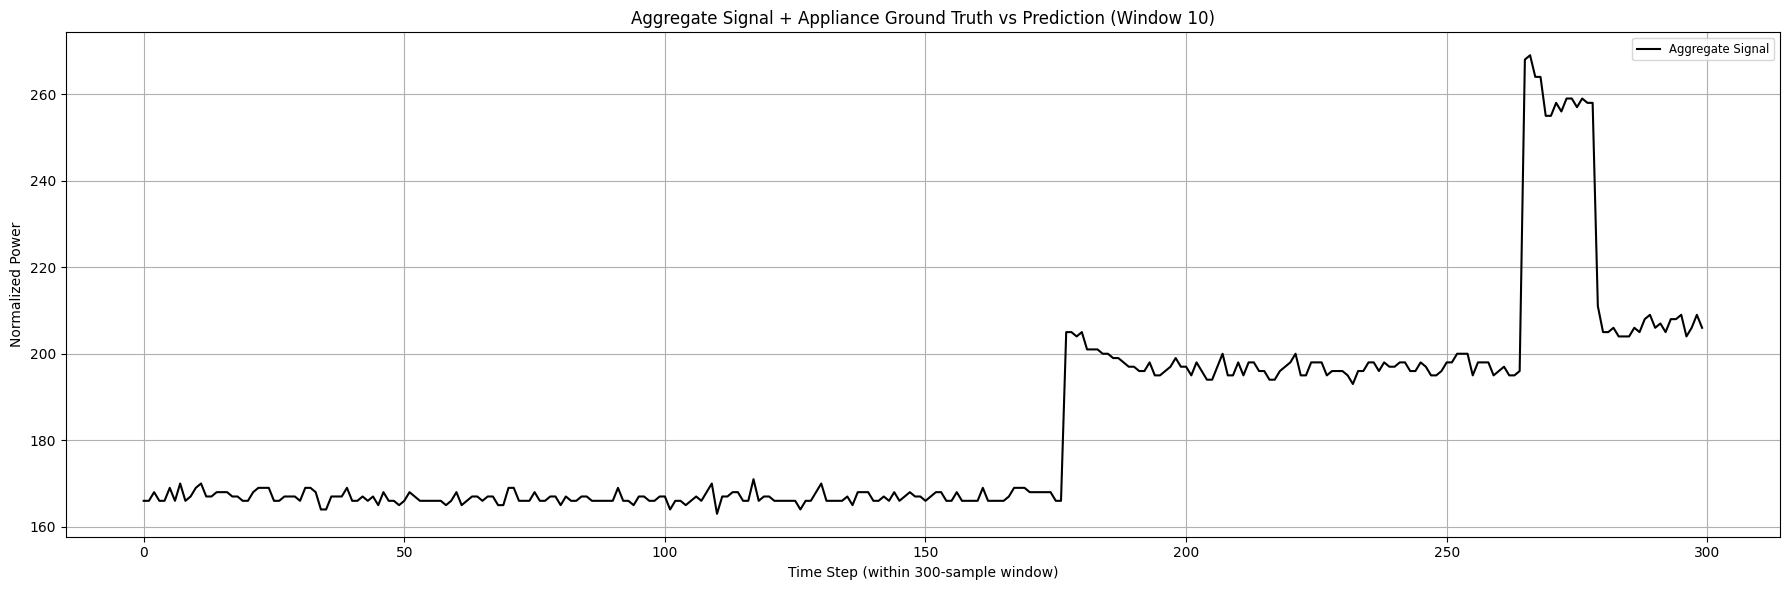

In [80]:

idx = 10  # window index to visualize
appliance_names = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
                   'Television', 'Microwave', 'Kettle', 'Hi-Fi', 'Electric Heater']
agg_signal = X_test[idx].squeeze()  # shape: (300,)
true_appliances = y_test[idx]       # shape: (9,)
pred_appliances = preds_binary[idx] # shape: (9,)

plt.figure(figsize=(18, 6))

# Plot aggregate signal
plt.plot(agg_signal, label='Aggregate Signal', color='black')

# Overlay appliance ground truth
used_labels_true = set()
used_labels_pred = set()

for i in range(len(appliance_names)):
    true_val = true_appliances[i]
    if isinstance(true_val, np.ndarray):
        true_val = true_val.flatten()[0]

    pred_val = pred_appliances[i]
    if isinstance(pred_val, np.ndarray):
        pred_val = pred_val.flatten()[0]


    y_pos = agg_signal.max() * (0.95 - i * 0.05)
    
    if true_val == 1:
        label = f'{appliance_names[i]} (True)' if appliance_names[i] not in used_labels_true else None
        plt.axhline(y=y_pos, color='green', linestyle='-', linewidth=2, label=label)
        used_labels_true.add(appliance_names[i])
    if pred_val == 1:
        label = f'{appliance_names[i]} (Pred)' if appliance_names[i] not in used_labels_pred else None
        plt.axhline(y=y_pos, color='red', linestyle='--', linewidth=2, label=label)
        used_labels_pred.add(appliance_names[i])

plt.title(f"Aggregate Signal + Appliance Ground Truth vs Prediction (Window {idx})")
plt.xlabel("Time Step (within 300-sample window)")
plt.ylabel("Normalized Power")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
